# Lab 3: Vegetation analysis using SentinelHub and Sentinel-2 imagery

This notebook includes examples of working with the [Sentinel-2](https://registry.opendata.aws/sentinel-2/) dataset using the [SentinelHub API]((https://www.sentinel-hub.com/) to query and download pre/post scenes over Mt. Shasta in California during the [Lava Fire](https://en.wikipedia.org/wiki/Lava_Fire_(2021)) from June 2021. You compare two images calculating an normalized difference vegetation index (NDVI) to identify vegetation and classify the result using a simple land cover classification scheme. 

<div class="alert alert-info">
This notebook is based on the GitHub repo <code>https://github.com/aws-samples/aws-sentinel2-smsl-notebook</code> and is updated for SageMaker AI Studio
</div>

## Install Packages
Install required packages

In [ ]:
# %pip install numpy
# %pip install matplotlib
# %pip install plotly_express
# %pip install sentinelhub[AWS]
# %pip install rasterio
# %pip install earthpy
# %pip install folium

## Import Packages
After the environment is created and selected or the packages installed manually, we can import them directly.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
import boto3
import sagemaker
warnings.filterwarnings('ignore')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Working With Geospatial Images
For Geospatial data, we will use Sentinel-2. The [Sentinel-2 mission](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) is a land monitoring constellation of two satellites that provide high resolution optical imagery and continuity for the current SPOT and Landsat missions. The Sentinel-2 dataset is available publicly at the [AWS open data registry](https://registry.opendata.aws/sentinel-2/).

We will use the `sentinelhub` python package, that makes it easy to search and download data specific to our focus area directly from AWS. 

In [2]:
from sentinelhub import SHConfig
config = SHConfig()

In [3]:
config

SHConfig(
  instance_id='********************************1719',
  sh_client_id='',
  sh_client_secret='',
  sh_base_url='https://services.sentinel-hub.com',
  sh_auth_base_url=None,
  sh_token_url='https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token',
  geopedia_wms_url='https://service.geopedia.world',
  geopedia_rest_url='https://www.geopedia.world/rest',
  aws_access_key_id='****************6WJ4',
  aws_secret_access_key='************************************UP01',
  aws_session_token='**********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

#### Sentinel Hub Setup
This section shows how to configure your credentials for sentinelhub. We are using a optional json file to store and retrieve credentials.

In [4]:
import json

# with open("config.json") as json_data_file:
#     cfg = json.load(json_data_file)

In [5]:
frozen_credentials = boto3.Session().get_credentials().get_frozen_credentials()

In [6]:
# Set your SentinelHub instance id here
sentinelhub_instance_id = 'ad7c1a32-4dcb-4d2a-ab6c-8418d7401719'

In [7]:
# instance_id - Instance ID from from your Sentinel Hub account 
# aws_access_key_id - Access key ID from your AWS account
# aws_secret_access_key - Secrect access key from your AWS account

config.instance_id = sentinelhub_instance_id
config.aws_access_key_id = frozen_credentials.access_key
config.aws_secret_access_key = frozen_credentials.secret_key
config.aws_session_token = frozen_credentials.token

In [8]:
# Save the configuration
config.save()

In [9]:
# Verify credentials

from sentinelhub import WebFeatureService, BBox, CRS, DataCollection, SHConfig
if config.instance_id == '':
    print("Warning! To use WFS functionality, please configure the `instance_id`.")

#### Data Search
Before we download, we need to specify our search coordinates that we want to study and the time window. In our case we are focusing on the Mt. Shasta region, which we specify as a bounding box and a time period corresponding to the Lava Fire (June 2021). 

In [10]:
# Specify bounding box and time interval for search. Here we are using a bounding box over the Mt. Shasta. We'll use the time that corresponds to pre/post fire event.

search_bbox = BBox(bbox=[-122.36984252929688,41.5327401,-122.20436096,41.4195597], crs=CRS.WGS84)

search_time_interval = ('2021-05-12T00:00:00', '2021-05-13T23:59:59')  #to include the post image expand to '2021-09-14T23:59:59'


wfs_iterator = WebFeatureService(
    search_bbox,
    search_time_interval,
    data_collection=DataCollection.SENTINEL2_L1C,
    maxcc=1.0,
    config=config
)

for tile_info in wfs_iterator:
    print(tile_info)

{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-123.0002278281736, 41.55183566201435], [-123.00022444079164, 40.56275892162145], [-121.70337428841314, 40.555482279532676], [-121.68381174361195, 41.54430266694568], [-123.0002278281736, 41.55183566201435]]]]}, 'properties': {'id': 'S2A_OPER_MSI_L1C_TL_VGS2_20210512T223857_A030755_T10TEL_N03.00', 'date': '2021-05-12', 'time': '19:13:07', 'path': 's3://sentinel-s2-l1c/tiles/10/T/EL/2021/5/12/0', 'crs': 'EPSG:32610', 'mbr': '499980,4490220 609780,4600020', 'cloudCoverPercentage': 0.71}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-123.00023106468512, 42.45268219265066], [-123.00022751961944, 41.4637608939765], [-121.68559366898083, 41.45625103879976], [-121.66512078076381, 42.444908861830775], [-123.00023106468512, 42.4526821

In [11]:
# List available tiles
wfs_iterator.get_tiles()

[('10TEL', '2021-5-12', 0), ('10TEM', '2021-5-12', 0)]

#### Picking Tiles
For best results, we pick a tile with least cloud coverage.

In [12]:
from sentinelhub.aws import AwsTile

tile_id = 'S2A_OPER_MSI_L1C_TL_VGS2_20210512T223857_A030755_T10TEL_N03.00'
tile_name, time, aws_index = AwsTile.tile_id_to_tile(tile_id)
tile_name, time, aws_index

tile_id2 = 'S2B_OPER_MSI_L1C_TL_VGS4_20210914T222623_A023634_T10TEL_N03.01'
tile_name2, time2, aws_index2 = AwsTile.tile_id_to_tile(tile_id2)
tile_name2, time2, aws_index2

/opt/conda/lib/python3.10/abc.py:106: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  cls = super().__new__(mcls, name, bases, namespace, **kwargs)


('10TEL', '2021-9-14', 0)

#### Sentinel Data Download
The Sentinel-2 satellites each carry a single multi-spectral instrument (MSI) with 13 spectral channels in the visible/near infrared (VNIR) and short wave infrared spectral range (SWIR). You can read more about these bands [here](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands). For our example will download eight specific bands that will aid our analysis.

In [15]:
warnings.simplefilter("ignore", UserWarning)
from sentinelhub.aws import AwsTileRequest

bands = ['B04','B08']  # Sentinel-2 imagery is comprised of several bands but we are only focusing on these for this analysis
metafiles = ['tileInfo', 'preview', 'qi/MSK_CLOUDS_B00']
data_folder = './AwsData'

request = AwsTileRequest(   # This corresponds to the first image request
    tile=tile_name,
    time=time,
    aws_index=aws_index,
    bands=bands,
    metafiles=metafiles,
    data_folder=data_folder,
    data_collection=DataCollection.SENTINEL2_L1C
)

request2 = AwsTileRequest(   # This corresponds to the second image request
    tile=tile_name2,
    time=time2,
    aws_index=aws_index2,
    bands=bands,
    metafiles=metafiles,
    data_folder=data_folder,
    data_collection=DataCollection.SENTINEL2_L1C
) 

/tmp/ipykernel_935/1589055334.py:8: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  request = AwsTileRequest(   # This corresponds to the first image request
/opt/conda/lib/python3.10/site-packages/sentinelhub/aws/request.py:149: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  self.aws_service = tile_class(
/opt/conda/lib/python3.10/site-packages/sentinelhub/aws/data.py:612: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = AwsDownloadClient(config=self.config, boto_params=REQUESTER_PAYS_PARAMS)
/tmp/ipykernel_935/1589055334.py:18: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  request2 = AwsTileRequest(   # This corresponds to the second image request


In [16]:
# This is where the download is triggered
request.save_data()
request2.save_data()  

/opt/conda/lib/python3.10/site-packages/sentinelhub/base.py:183: SHDeprecationWarning: AWS functionality will remain in the codebase for now, but won't be actively maintained.
  client = self.download_client_class(


## Working with Raster Data
Geospatial data is essentially comprised of raster data or vector data. Sentinel-2 uses GeoTIFF, a gridded raster datasets for satellite imagery and terrain models. Rasterio is a Python library that allows to read, inspect, visualize and write geospatial raster data. Here we use `rasterio` to read thee raster arrays and then use this data to create a true color image.

In [17]:
import rasterio
from rasterio import plot
import earthpy.spatial as es
import earthpy.plot as ep

The `earthpy` package allows easy plotting of visualization of bands, we use it here to visualize the NDVI

### Calculating Spectral Indices
Spectral indices are combinations of the pixel values from two or more spectral bands in a multispectral image. Spectral indices highlight pixels showing the relative abundance or lack of a land-cover type of interest in an image. Let's looks at a couple 

### Normalized Difference Vegetation Index - NVDI
The normalized difference vegetation index is a simple graphical indicator that can be used to analyze whether or not the target being observed contains live green vegetation. 

It calculated as `NDVI = (NIR – Red) / (NIR + Red)`

In [18]:
band4_image1 = rasterio.open('./AwsData/10TEL,2021-05-12,0/B04.jp2', driver='JP2OpenJPEG') #red
band8_image1 = rasterio.open('./AwsData/10TEL,2021-05-12,0/B08.jp2', driver='JP2OpenJPEG') #nir

band4_image2 = rasterio.open('./AwsData/10TEL,2021-09-14,0/B04.jp2', driver='JP2OpenJPEG') #red
band8_image2 = rasterio.open('./AwsData/10TEL,2021-09-14,0/B08.jp2', driver='JP2OpenJPEG') #nir

# read Red(b4) and NIR(b8) as arrays
red_image1 = band4_image1.read(1)
nir_image1 = band8_image1.read(1)
ndvi_image1 = (nir_image1.astype(float)-red_image1.astype(float))/(nir_image1.astype(float)+red_image1.astype(float))

red_image2 = band4_image2.read(1)
nir_image2 = band8_image2.read(1)
ndvi_image2 = (nir_image2.astype(float)-red_image2.astype(float))/(nir_image2.astype(float)+red_image2.astype(float))

### Creating a Simple Image Classification from NDVI
Remote Sensing data can be classified into thematic layers like land cover maps which are useful for representing spectral values as vegetation. This next section will create a 5-class map from the input NDVI images to compare differences in land cover change before and after the Lava Fire event occurred.

In [19]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_sentinel_class = np.digitize(ndvi_image1, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_sentinel_class = np.ma.masked_where(
    np.ma.getmask(ndvi_image1), ndvi_sentinel_class
)
#np.unique(ndvi_sentinel_class)

from matplotlib.colors import ListedColormap

# Define color map
nbr_colors = ["khaki", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "Dead forest",
    "Scrub",
    "Open Forest",
    "Moderately Dense Forest",
    "Very Dense Forest",
]

# Get list of classes
classes = np.unique(ndvi_sentinel_class)
classes = classes.tolist()

# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# Create classes and apply to NDVI results
ndvi_class_bins_2 = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_sentinel_class_2 = np.digitize(ndvi_image2, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_sentinel_class_2 = np.ma.masked_where(
    np.ma.getmask(ndvi_image2), ndvi_sentinel_class_2
)
#np.unique(ndvi_sentinel_class_2)

nbr_colors_2 = ["khaki", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap_2 = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names_2 = [
    "Dead forest",
    "Scrub",
    "Open Forest",
    "Moderately Dense Forest",
    "Very Dense Forest",
]

# Get list of classes
classes_2 = np.unique(ndvi_sentinel_class_2)
classes_2 = classes_2.tolist()
# The mask returns a value of none in the classes. remove that
classes_2 = classes_2[0:5]

## Plotting the Images

### NDVI Image Comparison

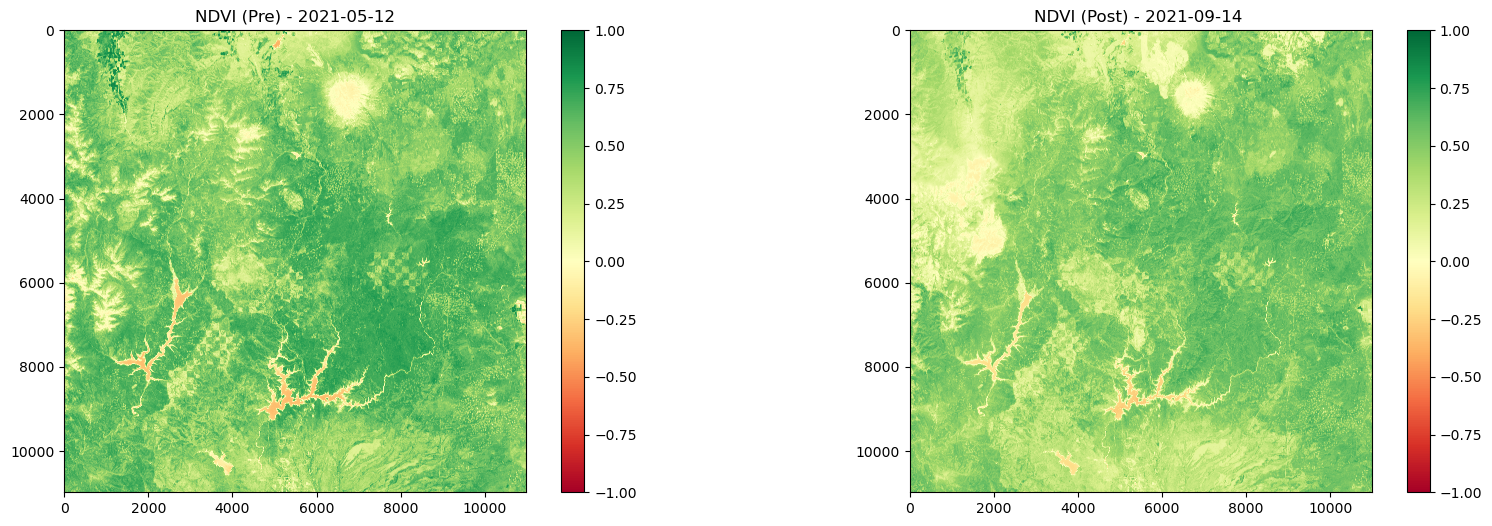

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6)) # 2 axes on a 1x2 grid

ndvi_image1 = ax1.imshow(ndvi_image1, cmap="RdYlGn")
ax1.set_title("NDVI (Pre) - 2021-05-12")
ndvi_image1.set_clim(vmin=-1, vmax=1)
fig.colorbar(ndvi_image1, ax=ax1)

# Now red band in the second subplot
ndvi_image2 = ax2.imshow(ndvi_image2, cmap="RdYlGn")
ax2.set_title("NDVI (Post) - 2021-09-14 ")
ndvi_image2.set_clim(vmin=-1, vmax=1)
fig.colorbar(ndvi_image2, ax=ax2)

You can see areas with vegetation in green, areas with dense vegetation as darker shades of green, water bodes generally have low to no vegetation and as such in a contrasting shade of orange. 

### Vegetation Classification Maps

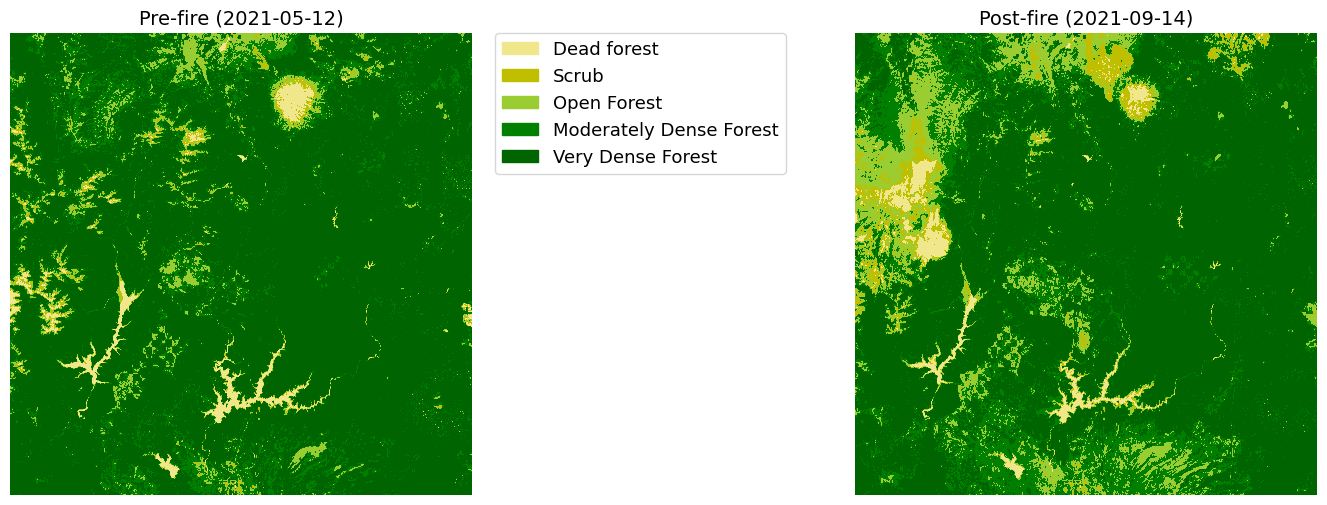

In [21]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6)) # 2 axes on a 1x2 grid

im1 = ax1.imshow(np.squeeze(ndvi_sentinel_class), cmap=nbr_cmap)
ep.draw_legend(im_ax=im1, classes=classes, titles=ndvi_cat_names)
ax1.set_title(
    "Pre-fire (2021-05-12)",
    fontsize=14)
ax1.set_axis_off()

# Auto adjust subplot to fit figure size
#plt.tight_layout()


im2 = ax2.imshow(np.squeeze(ndvi_sentinel_class_2), cmap=nbr_cmap_2)

#ep.draw_legend(im_ax=im2, classes=classes_2, titles=ndvi_cat_names_2)
ax2.set_title(
    "Post-fire (2021-09-14)",
    fontsize=14,
)
ax2.set_axis_off()

# Auto adjust subplot to fit figure size
#plt.tight_layout()


Here we see a comparison of pre/post fire classified NDVI images using some common vegetation classes representing different NDVI value ranges. Visually we see large areas of Very Dense / Moderately Dense Forest transformed into Dead Forest or Scrub following events of the Lava Fire.

## Clean Up (Optional)
Though we did not create any AWS billable resources as part of this exercise, the geographic and GIS data that we downloaded and the images generated may take up significant storage. Make sure to check any storage utilization and delete the files as needed.